###### **Polina V1.0.6**

**Credit Scoring**

Прогнозирование вероятности дефолта заемщика

Представьте, что вы работаете стажером в отделении регионального банка. Вы все также делаете запросы к базам данных и строите отчеты. Вы поймали себя на мысли, что представляли работу дата-саентиста совсем иначе…

И вот сегодня, когда вы уже были на пороге отчаяния, ваш начальник пришел к вам с долгожданной новостью. Будем строить модель!

“Отлично,” – думаете вы, – “наконец-то смогу заняться настоящей работой!”

Вашей задачей будет построить скоринг модель для вторичных клиентов банка, которая бы предсказывала вероятность дефолта клиента. Для этого нужно будет определить значимые параметры заемщика.

Условия соревнования:
Данное соревнование является бессрочным и доступно для всех потоков.

Срок выполнения соревнования устанавливается индивидуально в каждом потоке.

Тестовая выборка представлена в ЛидерБорде целиком.

Поэтому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).

Разрешено использовать любые ML алгоритмы и библиотеки (кроме DL).

Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

In [1]:
Credit Scoring
Прогнозирование вероятности дефолта заемщика

SyntaxError: invalid syntax (<ipython-input-1-059b9b440ee2>, line 1)

In [2]:
import pandas as pd
import numpy as np
from pandas import Series
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import f1_score, plot_confusion_matrix, accuracy_score, recall_score, precision_score


%matplotlib inline

In [3]:
sns.__version__



'0.10.0'

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-scoring/'
df_train = pd.read_csv(DATA_DIR+'/train.csv')
df_test = pd.read_csv(DATA_DIR+'/test.csv')

In [5]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
# df_train['sample'] = 1 # помечаем где у нас трейн
# df_test['sample'] = 0 # помечаем где у нас тест
# df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать,
                      # по этому пока просто заполняем нулями

#data = df_test.append(df_train, sort=False).reset_index(drop=True)

data = df_train.copy()

# Обработка пропусков

In [6]:
#визуализация пропусков
# fig, ax = plt.subplots(figsize=(20,12))
# sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [7]:
def preproc_na_df(df):
    # fill null in education
    most_common = df['education'].mode()
    df['education'].fillna(most_common[0], inplace=True)
    return df

In [8]:
# пропуски только в education, удаляем
data.dropna(axis=0, inplace=True)
# удаляем client_id
data.drop('client_id', axis=1, inplace=True)


# Рассмотрение числовых, бинарных и категориальных признаков

In [9]:
data.sample(4)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
25997,08MAR2014,GRD,M,47,N,N,0,0,-1.691971,1,50,2,3,25000,3,2,N,1
19635,06FEB2014,GRD,F,32,Y,Y,2,0,-1.601453,0,80,2,3,30000,1,4,Y,0
66307,07FEB2014,GRD,M,45,Y,Y,0,0,-1.723729,0,40,1,2,40000,1,4,Y,0
54955,04MAR2014,UGR,F,41,N,N,0,0,-1.727657,0,50,1,2,20000,1,3,N,0


In [10]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport' ]
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

In [11]:
"""Проверяет, совпадает ли множество категорий в тестовой и учебной выборках"""


def check_categories_in_dfs():    
    err=0
    for col in cat_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    for col in bin_cols:
        if data[col].nunique() != df_test[col].nunique():
            print(col, data[col].unique(), 'vs.', df_test[col].unique())
            err += 1
    if err==0:
        print('Категории в учебной и тестовой выборках идентичны')

In [12]:
check_categories_in_dfs()

Категории в учебной и тестовой выборках идентичны


# Генерируем новые признаки

In [13]:
# давность подачи заявки в днях
data['days_to_app'] = (pd.to_datetime(datetime.now()) - pd.to_datetime(data['app_date'])).apply(lambda x: x.days)
min_val = data['days_to_app'].min()
data['days_to_app'] = data['days_to_app'].apply(lambda x: x-min_val)
# месяц подачи заявки
data['month_app'] = pd.to_datetime(data['app_date']).apply(lambda x: x.month)

In [14]:
data['days_to_app'].min(), data['days_to_app'].max()

(0, 119)

В датасете представлены данные за 120 дней
Это данные за 4 месяца - с января по апрель

In [15]:
data['month_app'].value_counts()

3    21085
2    17938
4    17636
1    16833
Name: month_app, dtype: int64

In [16]:
if 'days_to_app' not in num_cols:
    num_cols.append('days_to_app')
num_cols

['age',
 'decline_app_cnt',
 'score_bki',
 'bki_request_cnt',
 'income',
 'days_to_app']

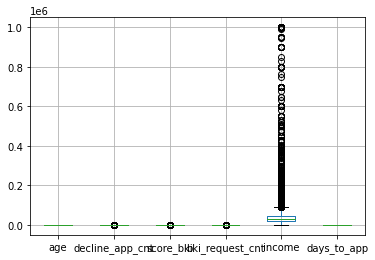

In [17]:
data[num_cols].boxplot()

In [18]:
def has_outliers(column, df=data):

    q25, q75 = np.percentile(df[column], [25, 75], axis=0)
    iqr = q75-q25
    lower_bound = q25 - 1.5*iqr
    upper_bound = q75 + 1.5*iqr
    
#     print('---------------------------')
#     print('Границы выбросов: ', lower_bound, ', ', upper_bound)
#     print('---------------------------')

    ok_values_cnt = (df[column].loc[df[column].between(
        lower_bound, upper_bound)]).count()
    outliers_cnt = df[column].count() - ok_values_cnt

    print('Количество выбросов', outliers_cnt)
    print('---------------------------')

In [19]:
for col in num_cols:
    print(col.upper())
    has_outliers(col)
    print(col.upper(), 'LOG')
    has_outliers(col, np.log1p(data[num_cols]))

AGE
Количество выбросов 0
---------------------------
AGE LOG
Количество выбросов 0
---------------------------
DECLINE_APP_CNT
Количество выбросов 12561
---------------------------
DECLINE_APP_CNT LOG
Количество выбросов 12561
---------------------------
SCORE_BKI
Количество выбросов 349
---------------------------
SCORE_BKI LOG
Количество выбросов 2961
---------------------------
BKI_REQUEST_CNT
Количество выбросов 1747
---------------------------
BKI_REQUEST_CNT LOG
Количество выбросов 9
---------------------------
INCOME
Количество выбросов 4672
---------------------------
INCOME LOG
Количество выбросов 1758
---------------------------
DAYS_TO_APP
Количество выбросов 0
---------------------------
DAYS_TO_APP LOG
Количество выбросов 2768
---------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log1p
  """


In [20]:
def lookup_on_num_column(df, col_name):
    plt.figure(figsize=(6,4))
    
    sns.distplot(df[col_name], kde = False, rug=False)
    
    plt.show()
    #sns.histplot(data=df[col_name])
    sns.distplot(np.log1p(df[col_name]), kde = False, rug=False)



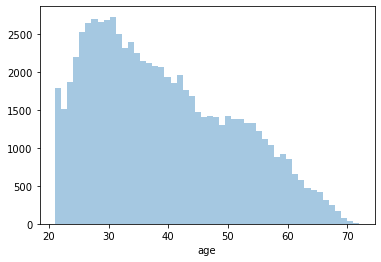

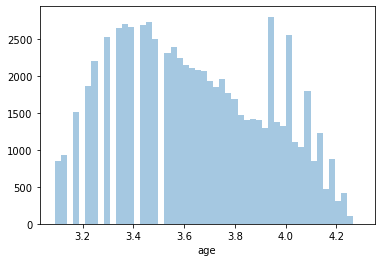

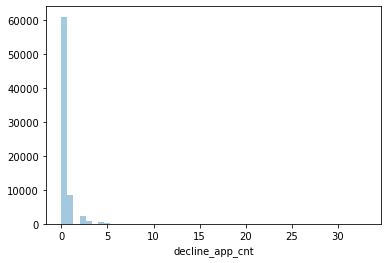

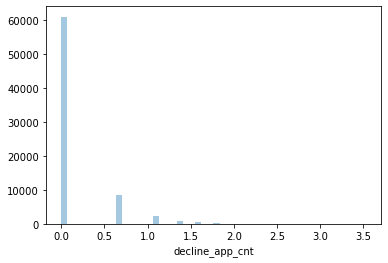

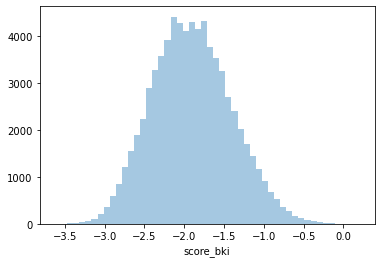

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


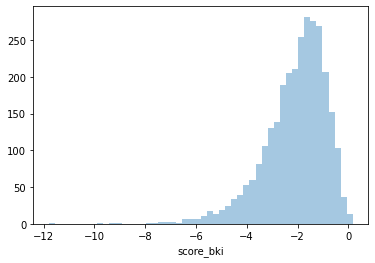

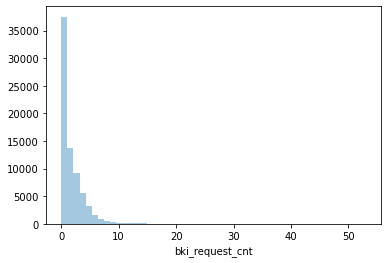

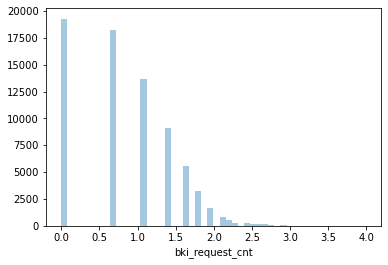

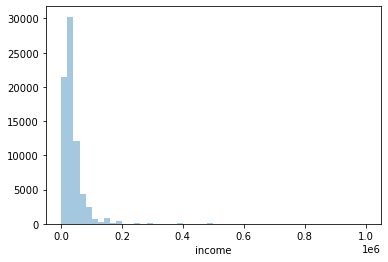

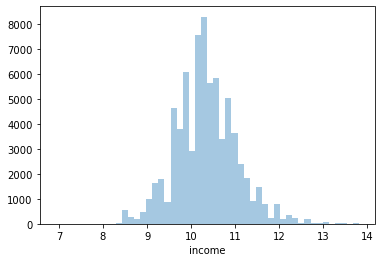

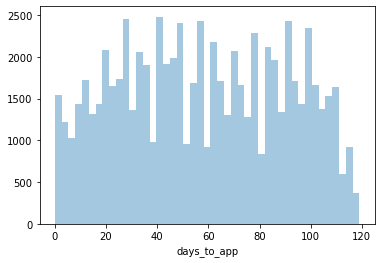

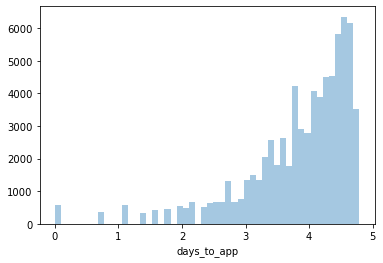

In [21]:
for col in num_cols:
    lookup_on_num_column(data, col)

## **Выводы о распределениях  по графикам:**

age - скорее лог-нормальное, признак логарифмируем

decline_app_cnt - почти все значения сосредоточены в нуле, распределение скорее лог-нормальное, выбросов меньше, когда признак логарифмируем, так и поступим

score_bki - нормальное распределение, выбросов не много

bki_request_cnt - скорее лог-нормальное, признак логарифмируем

income - лог-нормальное, выбросов много, пока все оставляем, признак логарифмируем

days_to_app - скорее равномерное с учетом "сезонных" колебаний


# Логарифмируем выбранные числовые признаки

In [22]:
cols_to_log1p = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
data[cols_to_log1p].apply(lambda x: np.log1p(x))

,age,decline_app_cnt,bki_request_cnt,income
0,4.143135,0.000000,0.693147,9.798183
1,4.094345,0.000000,1.386294,9.852247
2,3.258097,1.098612,0.693147,10.308986
3,3.988984,0.000000,1.098612,9.210440
4,3.891820,0.000000,0.693147,10.308986
...,...,...,...,...
73794,3.828641,0.000000,1.386294,9.741027
73795,3.737670,0.000000,0.693147,11.156265
73796,3.465736,0.000000,1.609438,10.714440
73797,3.401197,0.000000,1.386294,9.472782


# Посмотрим интересные истории распределения с учетом целевого default

In [23]:
def boxplot_for_numcols(df, col_name, hue_col=None):
    plt.figure()
    # sns.boxplot(x=df[hue_col], y=np.log1p(np.abs(df[col_name])))
    sns.boxplot(x=df[hue_col], y=df[col_name])

    plt.show

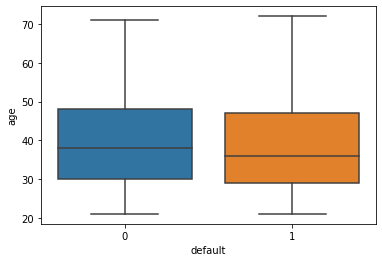

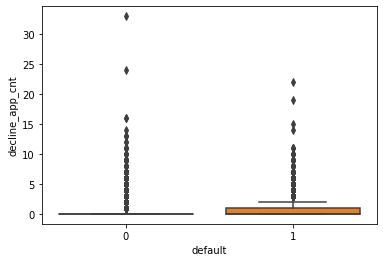

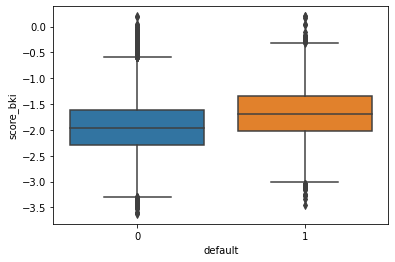

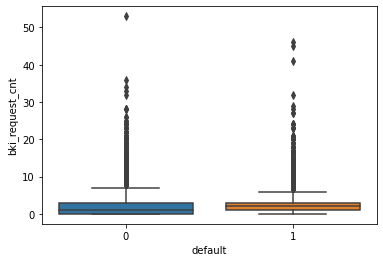

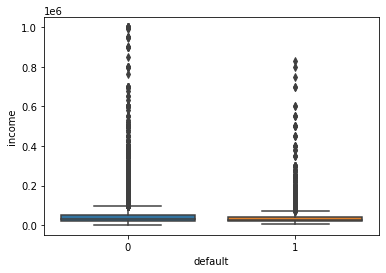

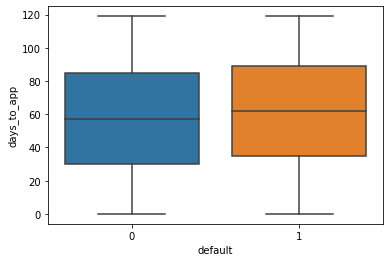

In [24]:
for column in num_cols:
    boxplot_for_numcols(data, column, 'default')

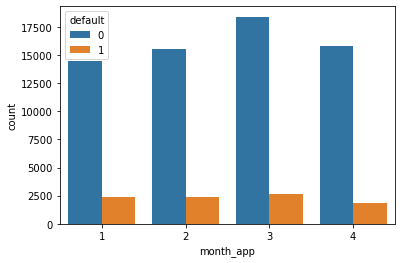

In [25]:
sns.countplot(x='month_app', data=data, hue='default')

судя по распределнию 

## выводы о наблюдениях

средний возраст дефолта меньше, чем недефолта

значение skore_bki выше у дефолта, чем у недефолта 

bki_request_cnt больше у дефолта чем у недефолта

days_to_app (давность подачи заявки) больше у недефолта

In [26]:
data.where(data['decline_app_cnt']==0).groupby(by='default')['decline_app_cnt'].sum()

default
0.0    0.0
1.0    0.0
Name: decline_app_cnt, dtype: float64

In [27]:
data.where(data['decline_app_cnt']>0).groupby(by='default')['decline_app_cnt'].sum()

default
0.0    15499.0
1.0     4819.0
Name: decline_app_cnt, dtype: float64

In [28]:
data.groupby('default')['income'].median()

default
0    30000
1    28000
Name: income, dtype: int64

# Корреляция между числовыми признаками

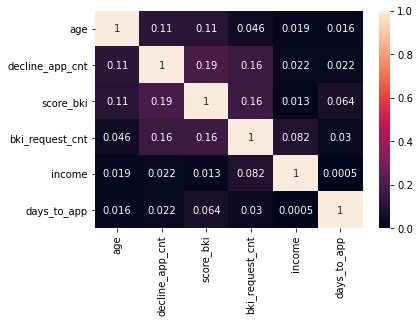

In [29]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

##  Вывод про корреляцию
Видим, что абсолютные значения корреляции не большие (макс - 0.19) - т.е признаки можем считать независимыми, и добавлять их в модель все

# Построение ANOVA-f метрики для оценки значимости числовых признаков

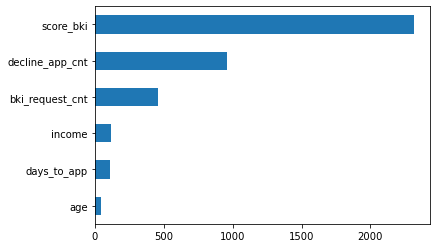

In [30]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# Работа с бинарными признаками - перекодировка в числовые (0, 1)

In [31]:
label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])

In [32]:
data.sample(5)

,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_to_app,month_app
18833,03MAR2014,SCH,0,21,0,0,0,1,-1.718410,0,80,2,3,25000,2,1,1,0,58,3
56056,05FEB2014,SCH,0,29,0,0,0,0,-2.555993,2,60,2,3,10000,1,3,0,1,84,2
24797,09MAR2014,GRD,0,25,0,0,0,0,-2.128638,1,50,1,3,45000,2,2,0,0,52,3
47614,28APR2014,SCH,0,61,0,0,0,0,-2.069180,2,60,2,3,13000,1,3,0,0,2,4
34367,04APR2014,GRD,0,38,1,0,0,0,-1.852617,0,60,2,3,50000,1,3,0,0,26,4


### Категориальные признаки тоже надо сделать числовыми

In [33]:
cat_cols

['education',
 'region_rating',
 'home_address',
 'work_address',
 'sna',
 'first_time']

In [34]:
print(data['education'].unique())
data['education'] = label_encoder.fit_transform(data['education'])
print(dict(enumerate(label_encoder.classes_)))

['SCH' 'GRD' 'UGR' 'PGR' 'ACD']
{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


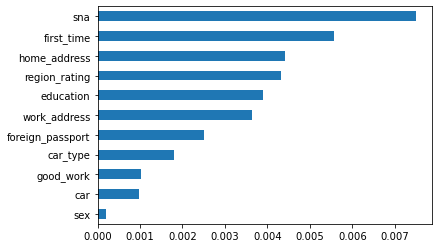

In [35]:
imp_cat = Series(mutual_info_classif(
    data[bin_cols + cat_cols], data['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

In [36]:
fig = px.parallel_coordinates(data, dimensions=['decline_app_cnt',
        'default'], color='default')
fig.show()

In [37]:
fig = px.parallel_coordinates(data, dimensions=['sna',
        'default'], color='default')
fig.show()

## One-hot encoding для категориальных переменных

In [38]:
# data_tr_cat = data[data['sample']==1][cat_cols]
# data_tr_cat
# X_tr_cat = OneHotEncoder(sparse = False).fit_transform(data_tr_cat.values)
# X_tr_cat.shape

In [39]:
# data_test_cat = data[data['sample']==0][cat_cols]
# data_test_cat
# X_test_cat = OneHotEncoder(sparse = False).fit_transform(data_test_cat.values)
# X_test_cat.shape

In [40]:

X_cat = OneHotEncoder(sparse = False).fit_transform(data[cat_cols].values)
X_cat.shape

(73492, 26)

# Собираем вместе все преобразованные части датасета

###### числовые - 
###### категориальные - преобразованы в числовые, сделан one-hot (dummies)
###### бинарные



In [41]:
X = np.hstack([data[num_cols], data[bin_cols].values, X_cat])

Y = data['default'].values

# тут функция обработки данных

In [42]:
def proc_data(df):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-42-5595323c1cd9>, line 2)

# Разбиваем выборку на учебную и тестовую

In [43]:
# train_data = data.query('sample == 1').drop(['sample'], axis=1)
# test_data = data.query('sample == 0').drop(['sample'], axis=1)


# X = train_data.drop(['default'], axis=1)
# y = train_data.Rating.values            # наш таргет


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

## Стандартизуем числовые признаки отдельно тренировочной, отдельно тестовой выборок

In [45]:
l = len(num_cols)
scaler = StandardScaler()

X_train[:,:l] = scaler.fit_transform(X_train[:,:l]).copy()

X_test[:,:l] = scaler.transform(X_test[:,:l])



In [46]:
model = LogisticRegression( max_iter=300)


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [47]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
Sp = tn / (tn+fp)
# Se = tp / (tp+fn)
# Re = tp / (tp+fn)
# Pr = tp / (tp+fp)
# Ac = (tn+tp) / (tp+tn+fp+fn)
# print('Acc=%.4f.  Pr=%.4f.  Re=%.4f.  Se=%.4f.  Sp=%.4f' % (Ac , Pr , Re , Se , Sp))
print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
print('Precision: %.4f' % precision_score(y_test, y_pred))
print('Recall: %.4f' % recall_score(y_test, y_pred))
print('Specifity: %.4f' % Sp)
print('F1: %.4f' % f1_score(y_test, y_pred))

Accuracy: 0.8714
Precision: 0.4340
Recall: 0.0245
Specifity: 0.9953
F1: 0.0464


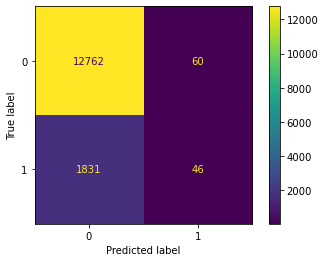

In [48]:
plot_confusion_matrix(model, X_test, y_test)  # doctest: +SKIP
plt.show()